# Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
%matplotlib inline

In [2]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

### Load the data into Pandas dataframe

In [3]:
df = pd.read_csv('/home/adewopva/OneDrive/Independent_Study/Thesis/34kcsvanotated.csv',delimiter=',',encoding='latin-1')
df.head()

,Unnamed: 0,text,annotation,target
0,0,best way to build empathy is through honesty a...,0,irrelevant
1,1,cryptocurrency scams replacing ransomware as a...,0,irrelevant
2,2,cryptocurrency scams replacing ransomware as a...,0,irrelevant
3,3,protect your customers access prestashop ant...,1,relevant
4,4,data leak from huazhu hotels may affect 130 mi...,1,relevant


Drop the columns that are not required for the neural network.

In [4]:
df.drop(['Unnamed: 0', 'target'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34193 entries, 0 to 34192
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        33942 non-null  object
 1   annotation  34193 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 534.4+ KB


In [5]:
df['text'] = df['text'].apply(str)

Understand the distribution better.

/home/adewopva/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Relevant and Irrelevant')

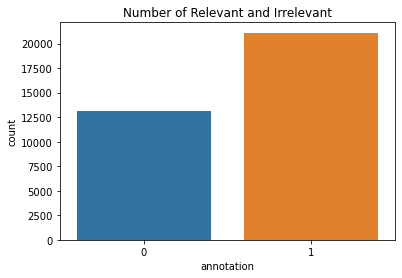

In [6]:
sns.countplot(df.annotation)
plt.xlabel('annotation')
plt.title('Number of Relevant and Irrelevant')

* Create input and output vectors.
* Process the labels.

In [65]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 40000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 61419 unique tokens.


In [66]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (34193, 150)


In [67]:
Y = pd.get_dummies(df['annotation']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (34193, 2)


In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(27354, 150) (27354, 2)
(6839, 150) (6839, 2)


### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

### RNN
Define the RNN structure.

In [69]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_NB_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(100,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [70]:
model = RNN()
model.summary()
#model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.compile(optimizer='RMSProp', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])#,metrics.mae, metrics.categorical_accuracy, metrics.categorical_crossentropy,metrics.binary_crossentropy])


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 100)               6500      
_________________________________________________________________
activation_6 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
out_layer (Dense)            (None, 2)                 202 

Fit on the training data.

In [71]:
# history=model.fit(X_train, Y_train,batch_size=64,epochs=10,
#           validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

batchSize = 32# int(X_train.shape[0]/50)
epochs_num =60
# build the model
history=model.fit(X_train, Y_train, epochs=epochs_num, batch_size=batchSize, validation_split=0.1)


Epoch 1/60
770/770 [==============================] - 9s 10ms/step - loss: 0.4389 - accuracy: 0.7756 - val_loss: 0.2901 - val_accuracy: 0.8618
Epoch 2/60
770/770 [==============================] - 8s 10ms/step - loss: 0.2845 - accuracy: 0.8681 - val_loss: 0.2815 - val_accuracy: 0.8670
Epoch 3/60
770/770 [==============================] - 8s 10ms/step - loss: 0.2615 - accuracy: 0.8897 - val_loss: 0.2782 - val_accuracy: 0.8662
Epoch 4/60
770/770 [==============================] - 8s 10ms/step - loss: 0.2483 - accuracy: 0.8958 - val_loss: 0.2977 - val_accuracy: 0.8582
Epoch 5/60
770/770 [==============================] - 7s 10ms/step - loss: 0.2222 - accuracy: 0.9065 - val_loss: 0.2866 - val_accuracy: 0.8677
Epoch 6/60
770/770 [==============================] - 8s 10ms/step - loss: 0.2052 - accuracy: 0.9218 - val_loss: 0.2812 - val_accuracy: 0.8706
Epoch 7/60
770/770 [==============================] - 8s 10ms/step - loss: 0.1910 - accuracy: 0.9268 - val_loss: 0.3068 - val_accuracy: 0.8692

Epoch 58/60
770/770 [==============================] - 12s 16ms/step - loss: 0.0941 - accuracy: 0.9620 - val_loss: 0.8881 - val_accuracy: 0.8355
Epoch 59/60
770/770 [==============================] - 13s 17ms/step - loss: 0.0923 - accuracy: 0.9623 - val_loss: 0.8697 - val_accuracy: 0.8293
Epoch 60/60
770/770 [==============================] - 13s 17ms/step - loss: 0.0928 - accuracy: 0.9601 - val_loss: 0.9069 - val_accuracy: 0.8399


In [72]:
# Y_test=np.argmax(Y_test, axis=1)
# X_test=np.argmax(X_test, axis=1)

The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

Evaluate the model on the test set.

In [73]:
Y_test.shape

(6839, 2)

In [74]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, Y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 

Accuracy on training data: 0.9529501795768738% 
 Error on training data: 0.04704982042312622


In [75]:
pred_test= model.predict(X_test)
y_pred = pred_test.round()
scores2 = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))   

Accuracy on test data: 0.8454452157020569% 
 Error on test data: 0.15455478429794312


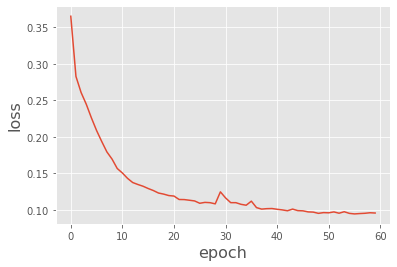

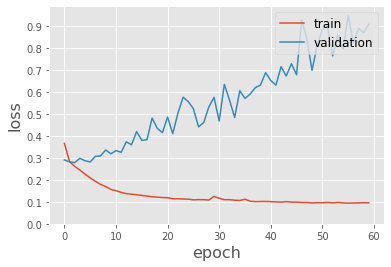

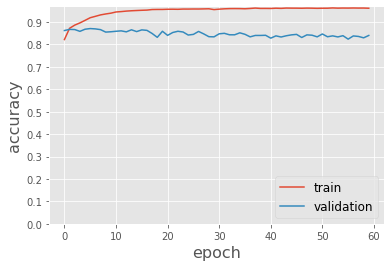

In [76]:
#Importing packages
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
#epochs_num=42
plt.plot(history.history['loss'])
plt.xlabel('epoch', fontsize=16)
#  plt.set_xlim(bottom=0)
# plt.xlim(left=0)#, right)
plt.ylabel('loss',fontsize=16)
#plt.savefig("./train_loss.jpg")
plt.show()
    
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right', fontsize ='large')
plt.ylabel('loss',fontsize=16)
plt.xlabel('epoch',fontsize=16)
plt.yticks(np.arange(0, 1.0, step=0.1))
plt.xticks(np.arange(0, epochs_num+10, step=10))
#plt.savefig("./all_loss.jpg")
plt.show()
    
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch',fontsize=16)
plt.ylabel('accuracy',fontsize=16)
plt.yticks(np.arange(0, 1.0, step=0.1))
plt.xticks(np.arange(0, epochs_num+10, step=10))
plt.legend(['train', 'validation'], loc='lower right', fontsize ='large')
#plt.savefig("./_accuracy.jpg")
plt.show()


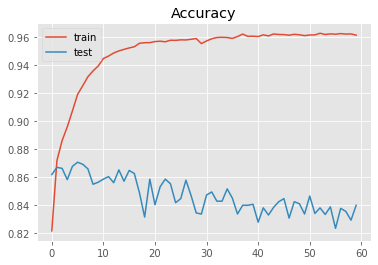

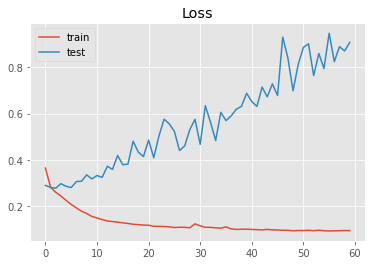

In [77]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [78]:
# import itertools
# #Function for Confusion Matrix
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
# #_______________________________________________________________________________
# y_pred=model.predict(X_test)
# y_pred=(y_pred.argmax(1))

# cnf_matrix =metrics.confusion_matrix(Y_test, y_pred)
# np.set_printoptions(precision=2)

# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=['No-Threat','Threat'],
#                       title='Confusion matrix, withnormalization')



Precision: 84.53268935516888%
Recall: 84.54452405322415%
f1_score: 84.53838007546507%

Confusion Matrix:
[[2092  534]
 [ 523 3690]]

Confusion matrix (normalised to % of total test data):
[[30.59  7.81]
 [ 7.65 53.96]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classified in the last category.


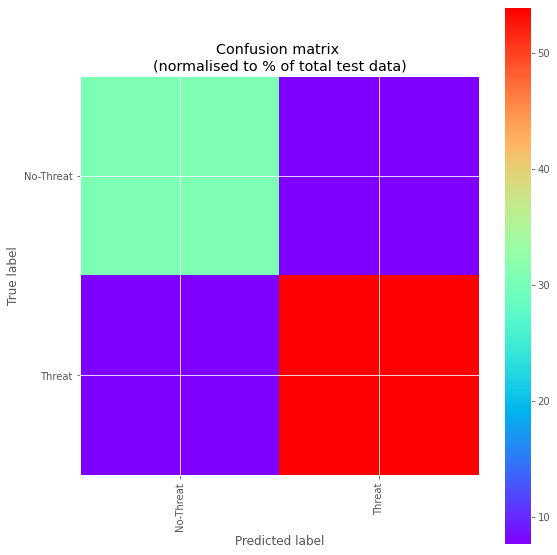

In [79]:
from sklearn import metrics
y_pred=model.predict(X_test)
y_pred=(y_pred.argmax(1)) 
Y_test=np.argmax(Y_test, axis=1)

#y_pred should be a tensor. Convert to numpy and get max along classes
#y_pred=np.multiply(y_pred, 1) 
#predictions = one_hot_predictions.argmax(1)

#print("Testing Accuracy: {}%".format(100*history.history['accuracy']))

print("")
print("Precision: {}%".format(100*metrics.precision_score(Y_test, y_pred, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Y_test, y_pred, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Y_test, y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Y_test, y_pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classified in the last category.")

# Plot Results:
width = 8
height = 8
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
n_classes=2
matrixLABELS = ['No-Threat','Threat']
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, matrixLABELS, rotation=90)
plt.yticks(tick_marks, matrixLABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Confusion matrix, without normalization
[[2092  534]
 [ 523 3690]]


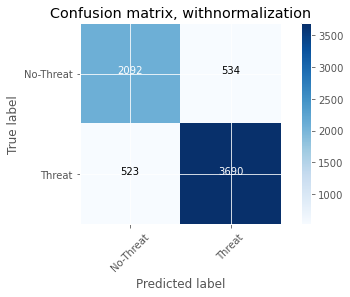

In [80]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
import itertools
#Function for Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#_______________________________________________________________________________
y_pred=model.predict(X_test)
y_pred=(y_pred.argmax(1))

cnf_matrix =metrics.confusion_matrix(Y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No-Threat','Threat'],
                      title='Confusion matrix, withnormalization')

In [211]:
df3=pd.read_csv("/home/adewopva/OneDrive/Independent_Study/Thesis/Colab Notebooks/tweetspredictbigdata.csv", )
df3=df3.drop_duplicates()


/home/adewopva/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (0,3,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [212]:
df3

,Unnamed: 0,name,tweet,retweets,location,created,followers,is_user_verified,clean
0,0,pilot_712,"@avast_antivirus @WIRED Thanks, will you post ...",0,"North East, England",02-Sep-2020,5,False,avast_antivirus wired thanks will you post ...
1,1,AwesomenessRM,@torproject @mullvadnet @avast_antivirus @Duck...,0,NaN,02-Sep-2020,1,False,torproject mullvadnet avast_antivirus duck...
2,2,diamondonyx7,@avast_antivirus please I need you guys to che...,0,NaN,01-Sep-2020,13,False,avast_antivirus please i need you guys to che...
3,3,CppProgrammer23,@hankadusikova @gregcons @avast_antivirus @CCl...,0,"Denver, CO",01-Sep-2020,8,False,hankadusikova gregcons avast_antivirus ccl...
4,4,pilot_712,@avast_antivirus @WIRED Presumably @avast_anti...,0,"North East, England",01-Sep-2020,5,False,avast_antivirus wired presumably avast_anti...
...,...,...,...,...,...,...,...,...,...
193714,167986,ANSSI_FR,The #Cyber Crisis Liaison Organisation Network...,4,Paris,29-Sep-2020,50045,True,the cyber crisis liaison organisation network...
193715,167987,ANSSI_FR,#BlueOlex20 aims to test the #EU preparedness ...,0,Paris,29-Sep-2020,50045,True,blueolex20 aims to test the eu preparedness ...
193716,167988,Cybersec_EU,"Join today at 14h00 CET, #CNECTUniversity’s se...",11,Brussels,28-Sep-2020,15830,False,join today at 14h00 cet cnectuniversity’s se...
193717,167989,SOMAObservatory,#TOMORROW our Project Coordinator @nikossarris...,3,"Greece, Athens",28-Sep-2020,2061,True,tomorrow our project coordinator nikossarris...


In [199]:
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
                
f=f.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/•(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[•^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
   # text=text.apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
f['clean']=f['clean'].apply(str)
f['clean'].apply(clean_text)
f.head()

,name,tweet,location,created,followers,verified,users,clean
0,pilot_712,@avast_antivirus @WIRED Presumably @avast_anti...,0,"North East, England",01-Sep-2020,5,False,avast_antivirus wired presumably avast_anti...
1,iamvishvadharam,"@XiaomiIndia @avast_antivirus Hi Good Morning,...",0,"New Delhi, India",01-Sep-2020,6,False,xiaomiindia avast_antivirus hi good morning ...
2,GklatenH,"@avast_antivirus Dear, Avast company, avast an...",0,"Klaten Utara, Indonesia",01-Sep-2020,32,False,avast_antivirus dear avast company avast an...
3,nealfunw,Fun fact: https://t.co/WIKchzVw9p redirects to...,0,"Klaten Utara, Indonesia",31-Aug-2020,9,False,fun fact https t co wikchzvw9p redirects to...
4,forzalez,• Ms Office 2019 pro plus (win 10) (windows &a...,0,"Klaten Utara, Indonesia",31-Aug-2020,1,False,• ms office 2019 pro plus win 10 windows &a...


In [214]:
df3.iloc[0:,4:]

,location,created,followers,is_user_verified,clean
0,"North East, England",02-Sep-2020,5,False,avast_antivirus wired thanks will you post ...
1,NaN,02-Sep-2020,1,False,torproject mullvadnet avast_antivirus duck...
2,NaN,01-Sep-2020,13,False,avast_antivirus please i need you guys to che...
3,"Denver, CO",01-Sep-2020,8,False,hankadusikova gregcons avast_antivirus ccl...
4,"North East, England",01-Sep-2020,5,False,avast_antivirus wired presumably avast_anti...
...,...,...,...,...,...
193714,Paris,29-Sep-2020,50045,True,the cyber crisis liaison organisation network...
193715,Paris,29-Sep-2020,50045,True,blueolex20 aims to test the eu preparedness ...
193716,Brussels,28-Sep-2020,15830,False,join today at 14h00 cet cnectuniversity’s se...
193717,"Greece, Athens",28-Sep-2020,2061,True,tomorrow our project coordinator nikossarris...


In [222]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 40000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150
# This is fixed.
EMBEDDING_DIM = 100
df3['clean']=df3['clean'].astype(str)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df3['clean'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

F= tokenizer.texts_to_sequences(df3['clean'].values)
F = pad_sequences(F, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', F.shape)

Found 246100 unique tokens.
Shape of data tensor: (167994, 150)


In [225]:
YT_pred = model.predict(F)
YT_pred=(YT_pred.argmax(1))
df3["pred_label"] = YT_pred
df3

,Unnamed: 0,name,tweet,retweets,location,created,followers,is_user_verified,clean,pred_label
0,0,pilot_712,"@avast_antivirus @WIRED Thanks, will you post ...",0,"North East, England",02-Sep-2020,5,False,avast_antivirus wired thanks will you post ...,1
1,1,AwesomenessRM,@torproject @mullvadnet @avast_antivirus @Duck...,0,NaN,02-Sep-2020,1,False,torproject mullvadnet avast_antivirus duck...,1
2,2,diamondonyx7,@avast_antivirus please I need you guys to che...,0,NaN,01-Sep-2020,13,False,avast_antivirus please i need you guys to che...,1
3,3,CppProgrammer23,@hankadusikova @gregcons @avast_antivirus @CCl...,0,"Denver, CO",01-Sep-2020,8,False,hankadusikova gregcons avast_antivirus ccl...,0
4,4,pilot_712,@avast_antivirus @WIRED Presumably @avast_anti...,0,"North East, England",01-Sep-2020,5,False,avast_antivirus wired presumably avast_anti...,1
...,...,...,...,...,...,...,...,...,...,...
193714,167986,ANSSI_FR,The #Cyber Crisis Liaison Organisation Network...,4,Paris,29-Sep-2020,50045,True,the cyber crisis liaison organisation network...,0
193715,167987,ANSSI_FR,#BlueOlex20 aims to test the #EU preparedness ...,0,Paris,29-Sep-2020,50045,True,blueolex20 aims to test the eu preparedness ...,1
193716,167988,Cybersec_EU,"Join today at 14h00 CET, #CNECTUniversity’s se...",11,Brussels,28-Sep-2020,15830,False,join today at 14h00 cet cnectuniversity’s se...,1
193717,167989,SOMAObservatory,#TOMORROW our Project Coordinator @nikossarris...,3,"Greece, Athens",28-Sep-2020,2061,True,tomorrow our project coordinator nikossarris...,0


In [227]:
df3.clean[193714]

'the  cyber crisis liaison organisation network   cyclone  is a new cooperation network   composed of the 27 member states 🇪🇺  launched during  blueolex20  enisa_eu  cybersec_eu  eu_commission  ncsc_nl  https   t co eyy8qakaru'

In [229]:
df3.to_csv('/home/adewopva/OneDrive/Independent_Study/Thesis/FEBPredictionsalldata.csv')